# Turn Direction Validation

This notebook checks whether turn-specific events (right vs left) produce the expected motor velocity signatures after the alignment timepoint (0 s). It reuses the aligned-data layout from `SANDBOX_3_mean_sem_grandav.py`, loads the corresponding CSV files, and compares the motor velocity before and after the event.

Run the configuration cell to point at your data directories and adjust analysis windows. Then execute the analysis cells to generate per-mouse summaries and optional visualisations.


In [46]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import math
import warnings
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})

sns.set_theme(style="whitegrid")


In [ ]:
# Configuration
# ----------------------------------------------------------------------
#HERE: COMMENT OUT PATHS YOU DON'T WANT TO RUN. For example, run analysis only for experimental day types. 
# Will automatically separate halt and no halt
# Root directories containing cohort-level folders with aligned data.
DATA_DIRS: List[Path] = [
    Path("/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day4").expanduser(),
    Path("/Volumes/RanczLab2/Cohort1_rotation/Visual_mismatch_day3").expanduser(),
]

# Event file suffixes that encode turn direction in their names.
EVENT_SUFFIXES: List[str] = [
    "_Apply halt_2s_right_turns_baselined_data.csv",
    "_Apply halt_2s_left_turns_baselined_data.csv",
    "_No halt_right_turns_baselined_data.csv",
    "_No halt_left_turns_baselined_data.csv",
]

# Optional subset of mice to analyse (use [] to include every mouse found).
SELECTED_MICE: List[str] = []

# Columns and time windows used for the velocity check.
TIME_COLUMN = "Time (s)"
VELOCITY_COLUMN = "Motor_Velocity_Baseline"
RUNNING_COLUMN = "Velocity_0X_Baseline"
PRE_WINDOW = (-1.0, 0.0)   # seconds relative to alignment (before 0)
POST_WINDOW = (0.0, 1.0)   # seconds relative to alignment (after 0)

# Threshold in deg/s to treat near-zero averages as no turn (avoid noisy sign flips).
ZERO_THRESHOLD = 1e-2

# Mapping from inferred turn direction to expected velocity sign after time 0.
# Here we expect the actual turn to be opposite the label in the filename.
EXPECTED_DIRECTION_SIGN = {
    "right": -1,  # filenames tagged "right" should result in negative velocity
    "left": 1,    # filenames tagged "left" should result in positive velocity
}



In [48]:
# Utility functions
# ----------------------------------------------------------------------

def _iter_raw_mouse_dirs(data_dirs: Iterable[Path]) -> Iterable[Tuple[str, Path]]:
    """Yield (mouse_id, raw_dir) pairs for each mouse found in the data dirs."""
    for data_dir in data_dirs:
        base = Path(data_dir)
        if not base.exists():
            print(f"⚠️ Data directory not found: {base}")
            continue
        for subdir in base.iterdir():
            if not subdir.is_dir() or subdir.name.endswith("_processedData"):
                continue
            mouse_id = subdir.name.split("-")[0]
            yield mouse_id, subdir


def find_turn_event_files(
    data_dirs: Iterable[Path],
    event_suffixes: Iterable[str],
    selected_mice: Optional[Iterable[str]] = None,
) -> List[Dict[str, object]]:
    """Locate aligned CSV files whose names encode turn direction."""
    selected = set(selected_mice or [])
    matches: List[Dict[str, object]] = []

    for mouse_id, raw_dir in _iter_raw_mouse_dirs(data_dirs):
        if selected and mouse_id not in selected:
            continue

        aligned_dir = raw_dir.parent / f"{raw_dir.name}_processedData" / "aligned_data"
        if not aligned_dir.exists():
            continue

        for suffix in event_suffixes:
            csv_path = aligned_dir / f"{mouse_id}{suffix}"
            if not csv_path.exists():
                continue
            direction = infer_direction_from_name(csv_path.name)
            group = infer_event_group(suffix)
            matches.append(
                {
                    "mouse": mouse_id,
                    "direction": direction,
                    "group": group,
                    "event_suffix": suffix,
                    "csv_path": csv_path,
                }
            )

    return matches


def infer_direction_from_name(filename: str) -> str:
    name = filename.lower()
    if "right" in name:
        return "right"
    if "left" in name:
        return "left"
    return "unknown"


def infer_event_group(name: str) -> str:
    lower = name.lower()
    if "no_halt" in lower or "no halt" in lower:
        return "No halt"
    if "apply" in lower:
        return "Apply halt"
    return "Unknown"


def load_time_series(
    csv_path: Path,
    time_column: str,
    value_column: str,
    value_alias: str = "velocity",
) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    if time_column not in df.columns:
        raise ValueError(f"Time column '{time_column}' not found in {csv_path}")
    if value_column not in df.columns:
        raise ValueError(f"Column '{value_column}' not found in {csv_path}")
    subset = df[[time_column, value_column]].copy()
    subset = subset.dropna()
    subset = subset.rename(columns={time_column: "time", value_column: value_alias})
    subset["time"] = pd.to_numeric(subset["time"], errors="coerce")
    subset[value_alias] = pd.to_numeric(subset[value_alias], errors="coerce")
    subset = subset.dropna()
    subset = subset.sort_values("time")
    return subset


def load_motor_velocity(
    csv_path: Path,
    time_column: str,
    velocity_column: str,
) -> pd.DataFrame:
    return load_time_series(csv_path, time_column, velocity_column, value_alias="velocity")


def compute_window_mean(df: pd.DataFrame, window: Tuple[float, float]) -> float:
    start, end = window
    mask = (df["time"] >= start) & (df["time"] < end if start < end else df["time"] <= end)
    if not mask.any():
        return float("nan")
    return float(df.loc[mask, "velocity"].mean())


def sign_with_threshold(value: float, threshold: float) -> int:
    if not math.isfinite(value) or abs(value) <= threshold:
        return 0
    return 1 if value > 0 else -1


def sem(values) -> float:
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n <= 1:
        return 0.0 if n == 1 else float("nan")
    return float(arr.std(ddof=1) / np.sqrt(n))


def assign_mouse_colors_consistent(mouse_ids: Iterable[str]) -> Dict[str, tuple]:
    normalized = [str(mouse) for mouse in mouse_ids]
    unique_mice = sorted(dict.fromkeys(normalized))
    if not unique_mice:
        return OrderedDict()
    palette = sns.color_palette("gnuplot2", len(unique_mice))
    return OrderedDict((mouse, palette[idx]) for idx, mouse in enumerate(unique_mice))


def analyse_turn_direction(
    df: pd.DataFrame,
    pre_window: Tuple[float, float],
    post_window: Tuple[float, float],
    zero_threshold: float,
) -> Dict[str, float]:
    pre_mean = compute_window_mean(df, pre_window)
    post_mean = compute_window_mean(df, post_window)
    pre_sign = sign_with_threshold(pre_mean, zero_threshold)
    post_sign = sign_with_threshold(post_mean, zero_threshold)
    direction_changed = (pre_sign != 0 and post_sign != 0 and pre_sign != post_sign)
    return {
        "pre_mean": pre_mean,
        "post_mean": post_mean,
        "pre_sign": pre_sign,
        "post_sign": post_sign,
        "direction_changed": direction_changed,
    }


def summarise_results(results: pd.DataFrame) -> pd.DataFrame:
    if results.empty:
        return results
    group_cols = ["group", "direction", "expected_sign"]
    grouped = (
        results.groupby(group_cols, dropna=False)
        .agg(
            n_files=("mouse", "count"),
            n_mice=("mouse", "nunique"),
            mean_post_velocity=("post_mean", "mean"),
            fraction_direction_change=("direction_changed", "mean"),
        )
        .reset_index()
    )
    grouped["fraction_direction_change"] = grouped["fraction_direction_change"].round(3)
    return grouped


def plot_motor_velocity(df: pd.DataFrame, title: str, pre_window, post_window) -> None:
    fig, ax = plt.subplots(figsize=(6, 3.5))
    ax.plot(df["time"], df["velocity"], color="#1f77b4", linewidth=0.9)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.axvspan(pre_window[0], pre_window[1], color="#2ca02c", alpha=0.15, label="Pre window")
    ax.axvspan(post_window[0], post_window[1], color="#d62728", alpha=0.15, label="Post window")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Motor velocity (deg/s)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()



In [49]:
# Load data and compute direction metrics
# ----------------------------------------------------------------------

turn_event_files = find_turn_event_files(DATA_DIRS, EVENT_SUFFIXES, SELECTED_MICE)
print(f"Found {len(turn_event_files)} turn-specific files")

records: List[Dict[str, object]] = []
trace_records: List[pd.DataFrame] = []
errors: List[str] = []

for entry in turn_event_files:
    csv_path = entry["csv_path"]
    try:
        df = load_motor_velocity(csv_path, TIME_COLUMN, VELOCITY_COLUMN)
    except Exception as exc:  # noqa: BLE001
        errors.append(f"{csv_path}: {exc}")
        continue

    metrics = analyse_turn_direction(df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
    expected_sign = EXPECTED_DIRECTION_SIGN.get(entry["direction"], np.nan)

    enriched_trace = df.copy()
    enriched_trace["group"] = entry["group"]
    enriched_trace["mouse"] = entry["mouse"]
    enriched_trace["direction"] = entry["direction"]
    enriched_trace["csv_path"] = str(csv_path)
    trace_records.append(enriched_trace)

    records.append(
        {
            **entry,
            **metrics,
            "expected_sign": expected_sign,
            "csv_path": str(csv_path),
        }
    )

results_df = pd.DataFrame(records)
trace_samples_df = pd.concat(trace_records, ignore_index=True) if trace_records else pd.DataFrame()

results_df


Found 38 turn-specific files


,mouse,direction,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,expected_sign
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.001898,-0.017356,0,-1,False,-1
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.001015,3.198218,0,1,False,1
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.005171,2.736037,0,1,False,-1
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000104,3.278545,0,1,False,1
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000401,-1.955065,0,-1,False,-1
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.001573,4.969472,0,1,False,1
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.000281,-2.576074,0,-1,False,-1
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,0.000642,2.509916,0,1,False,1
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.000847,-2.286672,0,-1,False,-1
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-0.001084,5.490400,0,1,False,1


In [50]:
# Inspect any files that could not be processed
errors


[]

In [51]:
# ----------------------------------------------------------------------
# Running velocity (Velocity_0X_Baseline) analysis
# ----------------------------------------------------------------------

running_records: List[Dict[str, object]] = []
running_trace_records: List[pd.DataFrame] = []
running_errors: List[str] = []

if not results_df.empty:
    for _, row in results_df.iterrows():
        csv_path = Path(row["csv_path"])
        try:
            running_df = load_time_series(csv_path, TIME_COLUMN, RUNNING_COLUMN, value_alias="velocity")
        except Exception as exc:  # noqa: BLE001
            running_errors.append(f"{csv_path}: {exc}")
            continue

        running_metrics = analyse_turn_direction(running_df, PRE_WINDOW, POST_WINDOW, ZERO_THRESHOLD)
        expected_sign = EXPECTED_DIRECTION_SIGN.get(row["direction"], np.nan)

        running_trace = running_df.copy()
        running_trace["group"] = row["group"]
        running_trace["mouse"] = row["mouse"]
        running_trace["turn_label"] = row["direction"]
        running_trace["csv_path"] = row["csv_path"]
        running_trace_records.append(running_trace)

        running_records.append(
            {
                "mouse": row["mouse"],
                "turn_label": row["direction"],
                "group": row["group"],
                "event_suffix": row["event_suffix"],
                "csv_path": row["csv_path"],
                **running_metrics,
                "expected_sign": expected_sign,
            }
        )

running_results_df = pd.DataFrame(running_records)
if not running_results_df.empty:
    running_results_df["direction"] = "All turns"
running_trace_samples_df = pd.concat(running_trace_records, ignore_index=True) if running_trace_records else pd.DataFrame()
if not running_trace_samples_df.empty:
    running_trace_samples_df["direction"] = "All turns"

running_results_df


,mouse,turn_label,group,event_suffix,csv_path,pre_mean,post_mean,pre_sign,post_sign,direction_changed,expected_sign,direction
0,B6J2718,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-3.920277e-06,-0.007501,0,0,False,-1,All turns
1,B6J2718,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-2.138606e-05,0.028418,0,1,False,1,All turns
2,B6J2718,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-1.252193e-05,0.013002,0,1,False,-1,All turns
3,B6J2718,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-6.143810e-06,0.003470,0,0,False,1,All turns
4,B6J2719,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,8.689382e-07,-0.002702,0,0,False,-1,All turns
5,B6J2719,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-3.951854e-05,0.063101,0,1,False,1,All turns
6,B6J2719,right,No halt,_No halt_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-8.684839e-06,0.014828,0,1,False,-1,All turns
7,B6J2719,left,No halt,_No halt_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-5.860019e-06,-0.000777,0,0,False,1,All turns
8,B6J2721,right,Apply halt,_Apply halt_2s_right_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,3.826424e-06,-0.000029,0,0,False,-1,All turns
9,B6J2721,left,Apply halt,_Apply halt_2s_left_turns_baselined_data.csv,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...,-5.755105e-05,0.088883,0,1,False,1,All turns


In [52]:
# Inspect any running-velocity files that could not be processed
running_errors


[]

### Running velocity summary


In [53]:
running_summary_df = summarise_results(running_results_df)
if running_summary_df.empty:
    print("⚠️ No running velocity statistics available")
else:
    for group_name, subdf in running_summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"#### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))


#### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,10,6,0.006639,0.0
1,All turns,1,10,6,0.046065,0.0


#### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,All turns,-1,9,5,0.008424,0.0
1,All turns,1,9,5,0.012137,0.0


In [54]:
if running_results_df.empty:
    running_mouse_means = pd.DataFrame()
else:
    running_mouse_means = (
        running_results_df.groupby(["group", "mouse"], dropna=False)
        .agg(
            post_mean=("post_mean", "mean"),
            pre_mean=("pre_mean", "mean"),
            n_files=("csv_path", "count"),
        )
        .reset_index()
    )
    running_mouse_means["expected_sign"] = np.nan
    running_mouse_means["post_sign"] = running_mouse_means["post_mean"].apply(lambda v: sign_with_threshold(v, ZERO_THRESHOLD))
    running_mouse_means["direction"] = "All turns"

running_mouse_means


,group,mouse,post_mean,pre_mean,n_files,expected_sign,post_sign,direction
0,Apply halt,B6J2717,0.044777,-1.666501e-05,2,NaN,1,All turns
1,Apply halt,B6J2718,0.019175,-1.057801e-05,4,NaN,1,All turns
2,Apply halt,B6J2719,0.025871,-2.020588e-05,4,NaN,1,All turns
3,Apply halt,B6J2721,0.046201,-2.226350e-05,4,NaN,1,All turns
4,Apply halt,B6J2722,0.027431,4.760679e-06,4,NaN,1,All turns
5,Apply halt,B6J2723,-0.018609,5.225198e-06,2,NaN,-1,All turns
6,No halt,B6J2717,-0.012150,2.888881e-07,2,NaN,-1,All turns
7,No halt,B6J2718,0.014690,-1.577756e-05,4,NaN,1,All turns
8,No halt,B6J2719,0.016607,-6.349192e-06,4,NaN,1,All turns
9,No halt,B6J2721,0.016322,-1.840072e-05,4,NaN,1,All turns


In [55]:
if running_trace_samples_df.empty:
    running_per_mouse_traces = pd.DataFrame()
    running_avg_traces = pd.DataFrame()
else:
    running_per_mouse_traces = (
        running_trace_samples_df
        .groupby(["group", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    running_per_mouse_traces["direction"] = "All turns"
    running_avg_traces = (
        running_per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

running_avg_traces


,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,All turns,-5.000,-0.032587,0.010630,6
1,Apply halt,All turns,-4.999,-0.032581,0.010632,6
2,Apply halt,All turns,-4.998,-0.032574,0.010635,6
3,Apply halt,All turns,-4.997,-0.032572,0.010636,6
4,Apply halt,All turns,-4.996,-0.032569,0.010639,6
...,...,...,...,...,...,...
29997,No halt,All turns,9.996,-0.047825,0.014842,5
29998,No halt,All turns,9.997,-0.047824,0.014842,5
29999,No halt,All turns,9.998,-0.047825,0.014839,5
30000,No halt,All turns,9.999,-0.047828,0.014839,5


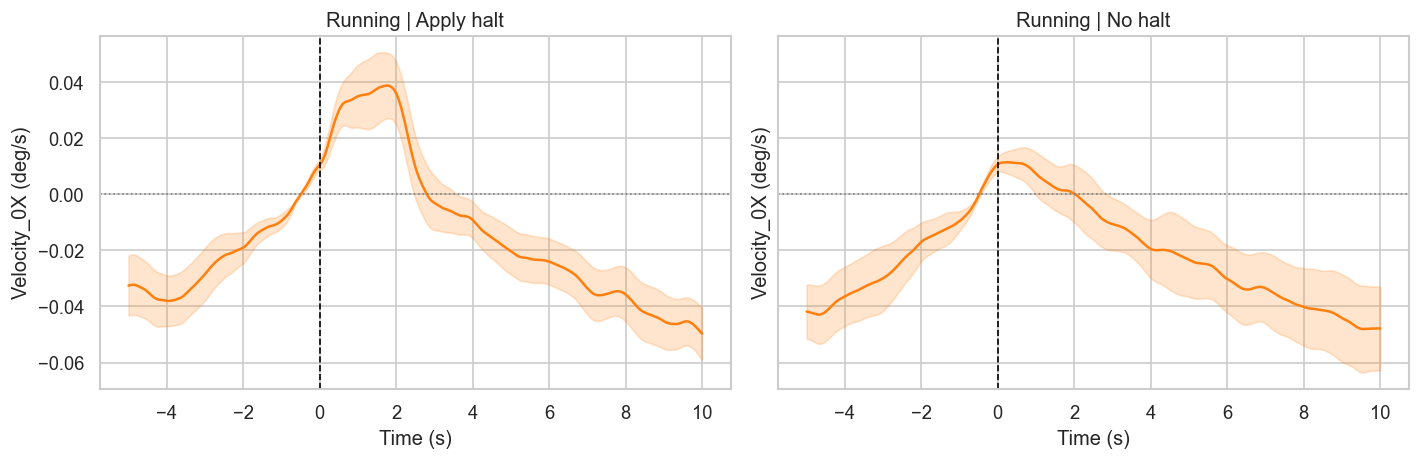

In [ ]:
if running_avg_traces.empty:
    print("⚠️ No running traces available for plotting")
else:
    plot_groups = ["Apply halt", "No halt"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, group_name in zip(axes, plot_groups):
        subset = running_avg_traces[running_avg_traces["group"] == group_name]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#ff7f0e", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#ff7f0e", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"Running | {group_name}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Velocity_0X (deg/s)")

    plt.tight_layout()
    plt.show()


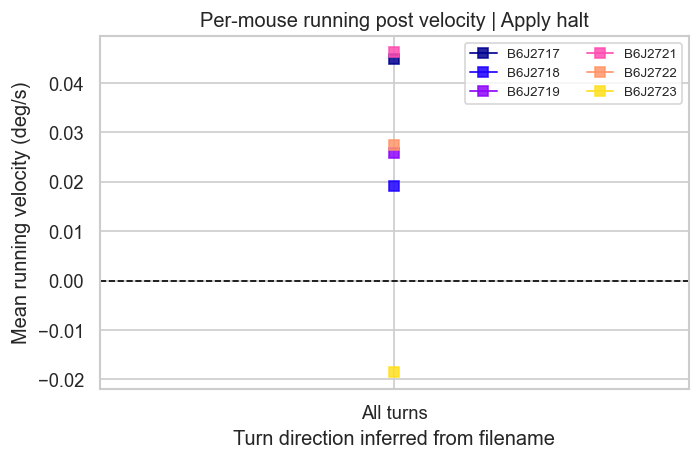

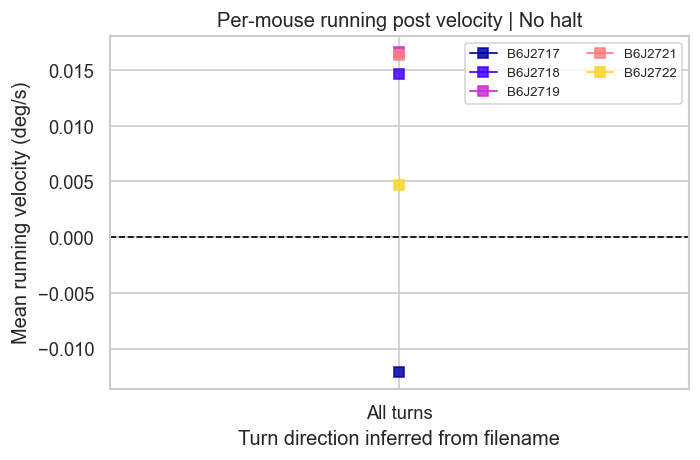

In [57]:
if running_mouse_means.empty:
    print("⚠️ No running per-mouse averages to plot")
else:
    for group_name, subset in running_mouse_means.groupby("group", dropna=False):
        if subset.empty:
            continue
        pivot = subset.pivot(index="mouse", columns="direction", values="post_mean")
        if pivot.empty:
            continue
        directions = sorted(pivot.columns.dropna())
        if not directions:
            continue
        x_positions = np.arange(len(directions))
        colors = assign_mouse_colors_consistent(pivot.index)
        fig, ax = plt.subplots(figsize=(6, 4))
        legend_handles = {}
        for mouse in pivot.index:
            series = pivot.loc[mouse, directions]
            if series.isna().all():
                continue
            line, = ax.plot(
                x_positions,
                series.to_numpy(dtype=float),
                marker="s",
                linewidth=1.2,
                alpha=0.85,
                color=colors.get(mouse, "#333333"),
            )
            legend_handles.setdefault(mouse, line)
        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(directions)
        ax.set_ylabel("Mean running velocity (deg/s)")
        ax.set_xlabel("Turn direction inferred from filename")
        label = group_name if isinstance(group_name, str) else "Unknown"
        ax.set_title(f"Per-mouse running post velocity | {label}")
        if legend_handles:
            ax.legend(legend_handles.values(), legend_handles.keys(), loc="upper right", fontsize=8, ncol=2)
        plt.tight_layout()



In [58]:
# Summary statistics
# ----------------------------------------------------------------------

summary_df = summarise_results(results_df)
if summary_df.empty:
    print("⚠️ No summary statistics available")
else:
    for group_name, subdf in summary_df.groupby("group", dropna=False):
        title = group_name if isinstance(group_name, str) else "Unknown"
        display(Markdown(f"### {title}"))
        display(subdf.drop(columns=["group"], errors="ignore").reset_index(drop=True))


### Apply halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,10,6,2.528827,0.0
1,right,-1,10,6,-2.473939,0.0


### No halt

,direction,expected_sign,n_files,n_mice,mean_post_velocity,fraction_direction_change
0,left,1,9,5,1.891076,0.0
1,right,-1,9,5,-0.621963,0.0


In [59]:
# ----------------------------------------------------------------------
# Per-mouse averages by turn direction
# ----------------------------------------------------------------------

if results_df.empty:
    mouse_direction_means = pd.DataFrame()
else:
    mouse_direction_means = (
        results_df.groupby(["group", "mouse", "direction"], dropna=False)
        .agg(
            post_mean=("post_mean", "mean"),
            pre_mean=("pre_mean", "mean"),
            n_files=("csv_path", "count"),
        )
        .reset_index()
    )
    mouse_direction_means["expected_sign"] = mouse_direction_means["direction"].map(EXPECTED_DIRECTION_SIGN)
    mouse_direction_means["post_sign"] = mouse_direction_means["post_mean"].apply(lambda v: sign_with_threshold(v, ZERO_THRESHOLD))

mouse_direction_means


,group,mouse,direction,post_mean,pre_mean,n_files,expected_sign,post_sign
0,Apply halt,B6J2717,left,-0.598381,-0.000928,1,1,-1
1,Apply halt,B6J2717,right,-4.245025,-0.001150,1,-1,-1
2,Apply halt,B6J2718,left,4.181582,0.001041,2,1,1
3,Apply halt,B6J2718,right,-0.837178,-0.002187,2,-1,-1
4,Apply halt,B6J2719,left,1.918644,0.003130,2,1,1
5,Apply halt,B6J2719,right,-1.722691,-0.001125,2,-1,-1
6,Apply halt,B6J2721,left,6.349681,-0.000173,2,1,1
7,Apply halt,B6J2721,right,-1.293078,-0.001354,2,-1,-1
8,Apply halt,B6J2722,left,-0.574423,0.002728,2,1,-1
9,Apply halt,B6J2722,right,-5.496786,0.001717,2,-1,-1


In [60]:
# ----------------------------------------------------------------------
# Average motor velocity traces by condition and turn direction
# ----------------------------------------------------------------------

if trace_samples_df.empty:
    per_mouse_traces = pd.DataFrame()
    avg_traces = pd.DataFrame()
else:
    per_mouse_traces = (
        trace_samples_df
        .groupby(["group", "direction", "mouse", "time"], dropna=False)["velocity"]
        .mean()
        .reset_index()
    )
    avg_traces = (
        per_mouse_traces
        .groupby(["group", "direction", "time"], dropna=False)
        .agg(
            mean_velocity=("velocity", "mean"),
            sem_velocity=("velocity", lambda x: sem(x) if len(x.dropna()) > 1 else 0.0),
            n_mice=("mouse", "nunique"),
        )
        .reset_index()
    )

avg_traces


,group,direction,time,mean_velocity,sem_velocity,n_mice
0,Apply halt,left,-5.000,9.484855,1.762178,6
1,Apply halt,left,-4.999,9.484675,1.761696,6
2,Apply halt,left,-4.998,9.484494,1.761212,6
3,Apply halt,left,-4.997,9.484317,1.760732,6
4,Apply halt,left,-4.996,9.484141,1.760249,6
...,...,...,...,...,...,...
59999,No halt,right,9.996,-10.865194,1.529601,5
60000,No halt,right,9.997,-10.865004,1.530279,5
60001,No halt,right,9.998,-10.864813,1.530956,5
60002,No halt,right,9.999,-10.864619,1.531633,5


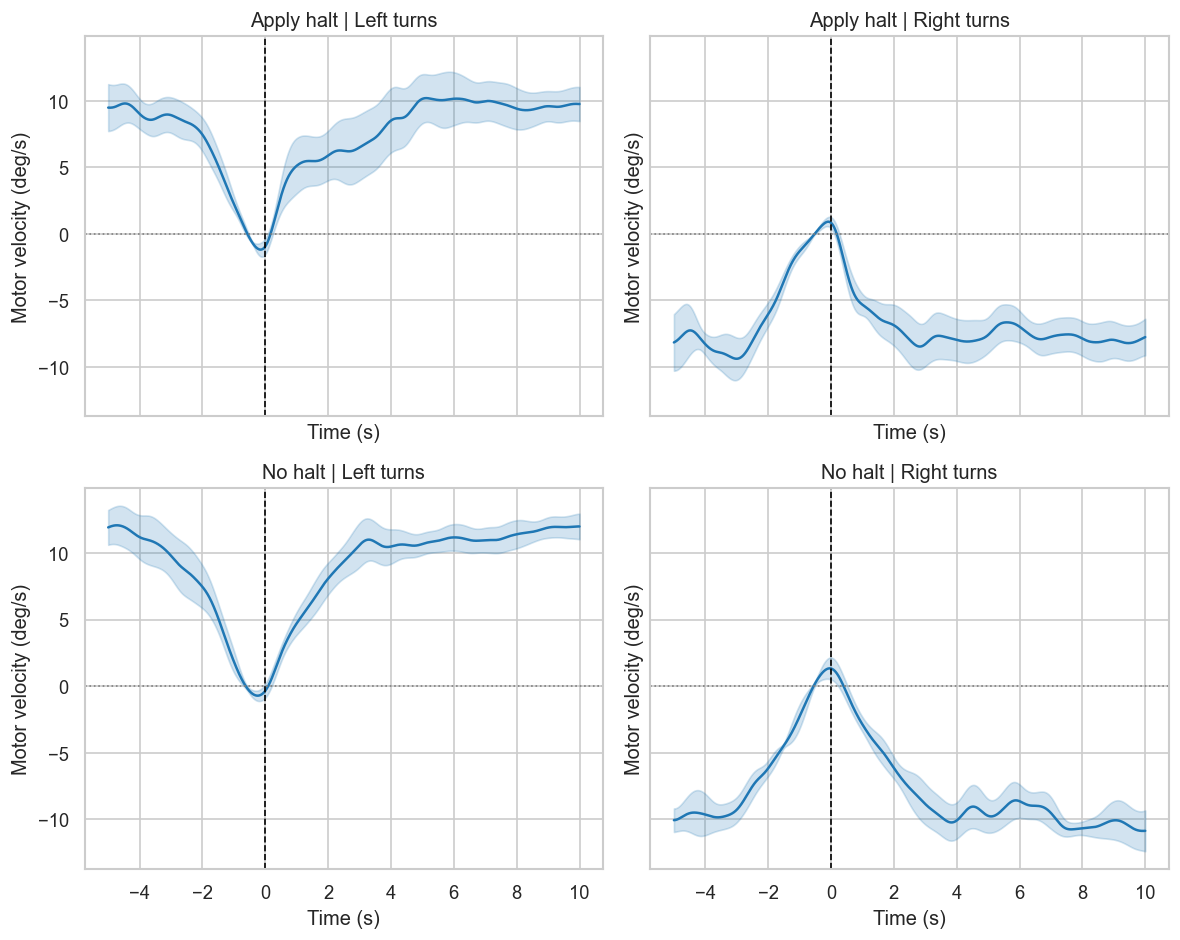

In [61]:
# ----------------------------------------------------------------------
# 2x2 average motor velocity figure (Apply halt / No halt x Left / Right)
# ----------------------------------------------------------------------

if avg_traces.empty:
    print("⚠️ No averaged traces available for plotting")
else:
    plot_order = [
        ("Apply halt", "left"),
        ("Apply halt", "right"),
        ("No halt", "left"),
        ("No halt", "right"),
    ]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, (group_name, direction) in zip(axes, plot_order):
        subset = avg_traces[
            (avg_traces["group"] == group_name)
            & (avg_traces["direction"] == direction)
        ]
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.axis("off")
            continue

        ax.plot(subset["time"], subset["mean_velocity"], color="#1f77b4", linewidth=1.5)
        if "sem_velocity" in subset.columns:
            upper = subset["mean_velocity"] + subset["sem_velocity"].fillna(0)
            lower = subset["mean_velocity"] - subset["sem_velocity"].fillna(0)
            ax.fill_between(subset["time"], lower, upper, color="#1f77b4", alpha=0.2)

        ax.axvline(0, color="black", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_title(f"{group_name} | {direction.capitalize()} turns")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Motor velocity (deg/s)")

    plt.tight_layout()
    plt.show()


### Expected Sign Reference

The `expected_sign` column comes from the `EXPECTED_DIRECTION_SIGN` mapping defined in the configuration. At the moment we assume the true turn is opposite to the label embedded in the filename: entries tagged `right` should yield a negative post-alignment motor velocity (turning left), while entries tagged `left` should yield a positive velocity.


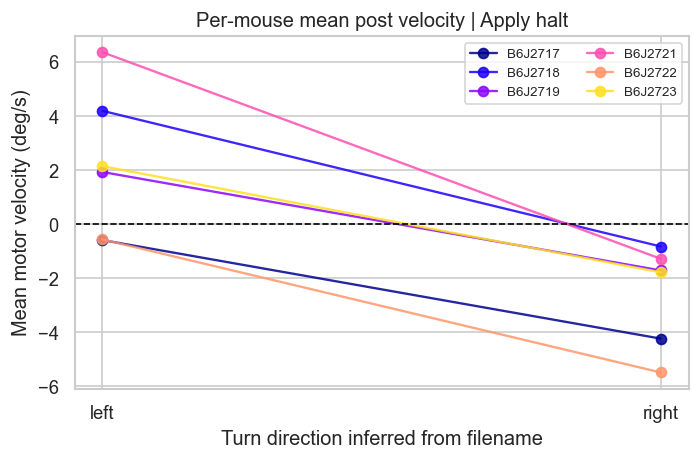

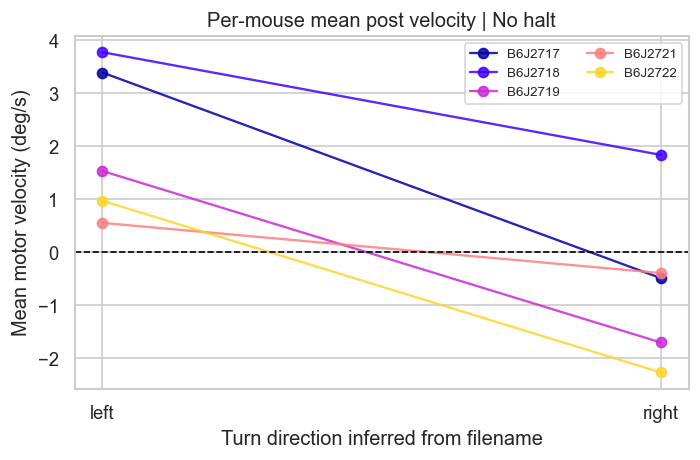

In [62]:
# Visualise per-mouse mean post velocity by labelled turn direction
if mouse_direction_means.empty:
    print("⚠️ No per-mouse averages to plot")
else:
    for group_name, subset in mouse_direction_means.groupby("group", dropna=False):
        if subset.empty:
            continue
        pivot = subset.pivot(index="mouse", columns="direction", values="post_mean")
        if pivot.empty:
            continue
        directions = sorted(pivot.columns.dropna())
        if not directions:
            continue
        x_positions = np.arange(len(directions))
        colors = assign_mouse_colors_consistent(pivot.index)
        fig, ax = plt.subplots(figsize=(6, 4))
        legend_handles = {}
        for mouse in pivot.index:
            series = pivot.loc[mouse, directions]
            if series.isna().all():
                continue
            line, = ax.plot(
                x_positions,
                series.to_numpy(dtype=float),
                marker="o",
                linewidth=1.4,
                alpha=0.85,
                color=colors.get(mouse, "#333333"),
            )
            legend_handles.setdefault(mouse, line)
        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(directions)
        ax.set_ylabel("Mean motor velocity (deg/s)")
        ax.set_xlabel("Turn direction inferred from filename")
        label = group_name if isinstance(group_name, str) else "Unknown"
        ax.set_title(f"Per-mouse mean post velocity | {label}")
        if legend_handles:
            ax.legend(legend_handles.values(), legend_handles.keys(), loc="upper right", fontsize=8, ncol=2)
        plt.tight_layout()



In [63]:
# Inspect individual traces
# ----------------------------------------------------------------------

if not results_df.empty:
    display_columns = ["mouse", "group", "direction", "post_mean", "direction_changed", "csv_path"]
    display(results_df[display_columns].reset_index(drop=True))
else:
    print("⚠️ No files available for inspection")


,mouse,group,direction,post_mean,direction_changed,csv_path
0,B6J2718,Apply halt,right,-0.017356,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
1,B6J2718,Apply halt,left,3.198218,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
2,B6J2718,No halt,right,2.736037,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
3,B6J2718,No halt,left,3.278545,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
4,B6J2719,Apply halt,right,-1.955065,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
5,B6J2719,Apply halt,left,4.969472,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
6,B6J2719,No halt,right,-2.576074,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
7,B6J2719,No halt,left,2.509916,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
8,B6J2721,Apply halt,right,-2.286672,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
9,B6J2721,Apply halt,left,5.490400,False,/Volumes/RanczLab2/Cohort1_rotation/Visual_mis...
